<a href="https://colab.research.google.com/github/klotardesignstudio/tradebao-cripto-poc/blob/main/03_backtest_rsi_reversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRADEBAO POC - NOTEBOOK 03: BACKTEST RSI REVERSION

In [6]:
# Célula 1: Instalação da Versão de Desenvolvimento do Pandas-TA e Imports

!pip install --upgrade pandas-ta

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("\nPandas-TA instalado com sucesso a partir do GitHub!")


Pandas-TA instalado com sucesso a partir do GitHub!


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


----- Processando ADABTC -----


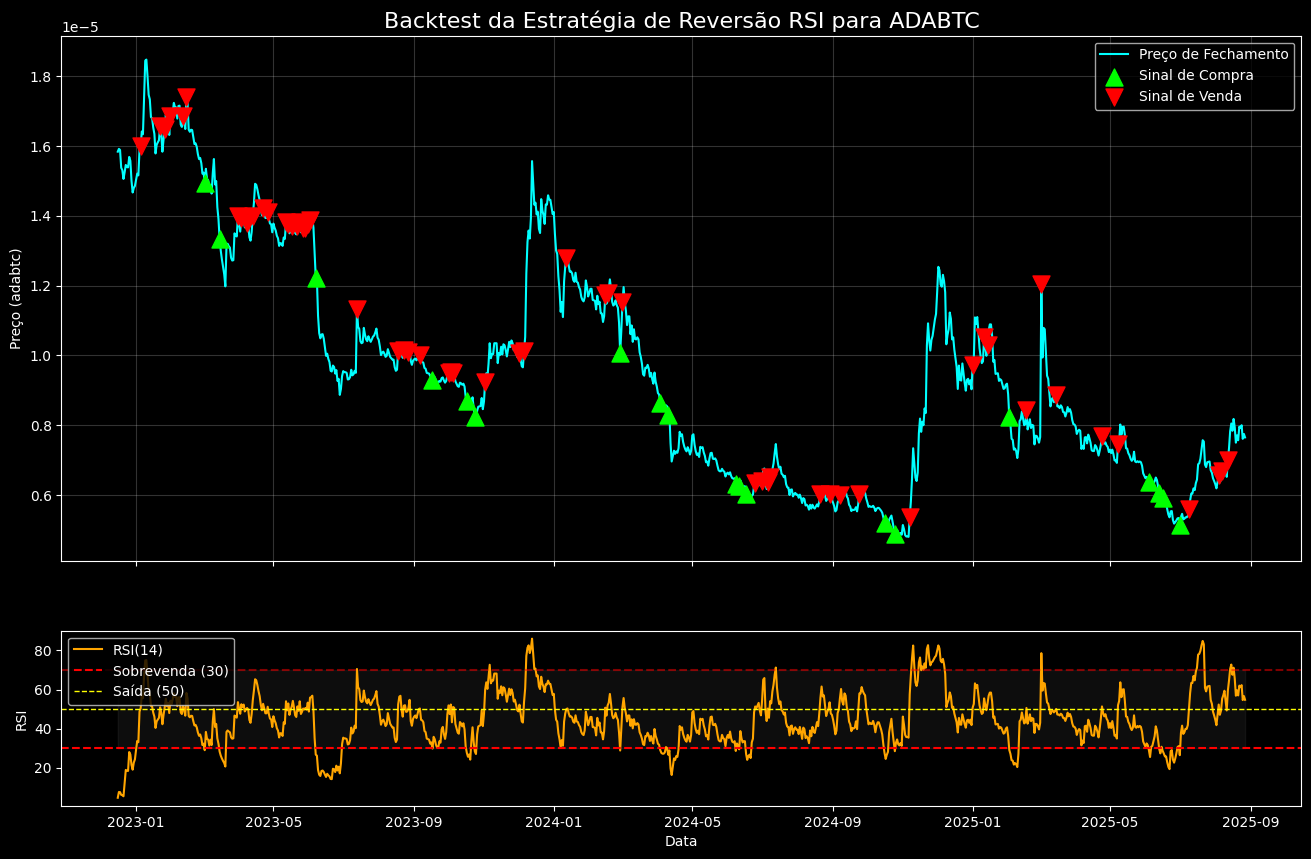

----- Processando ETHBTC -----


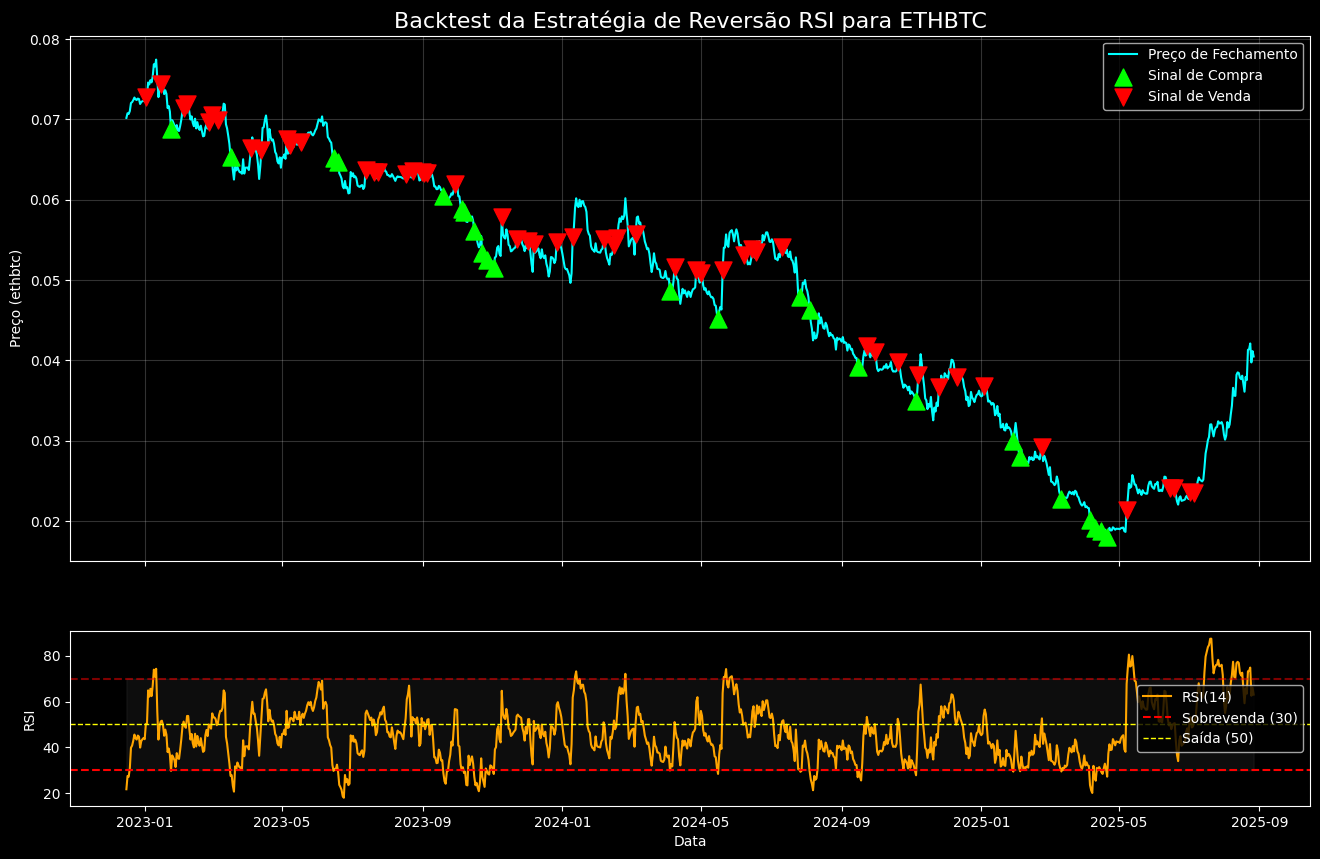

----- Processando LINKBTC -----


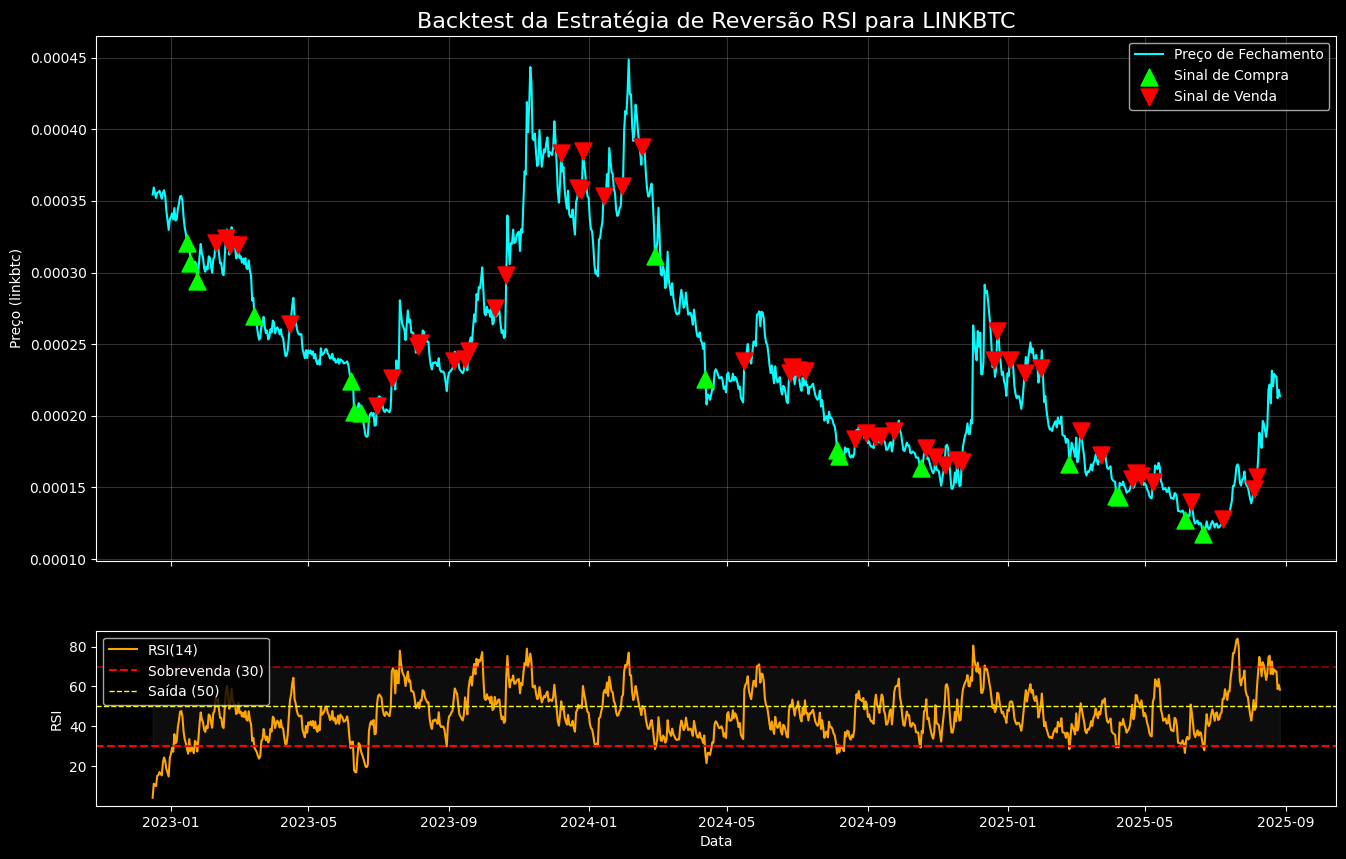

----- Processando SOLBTC -----


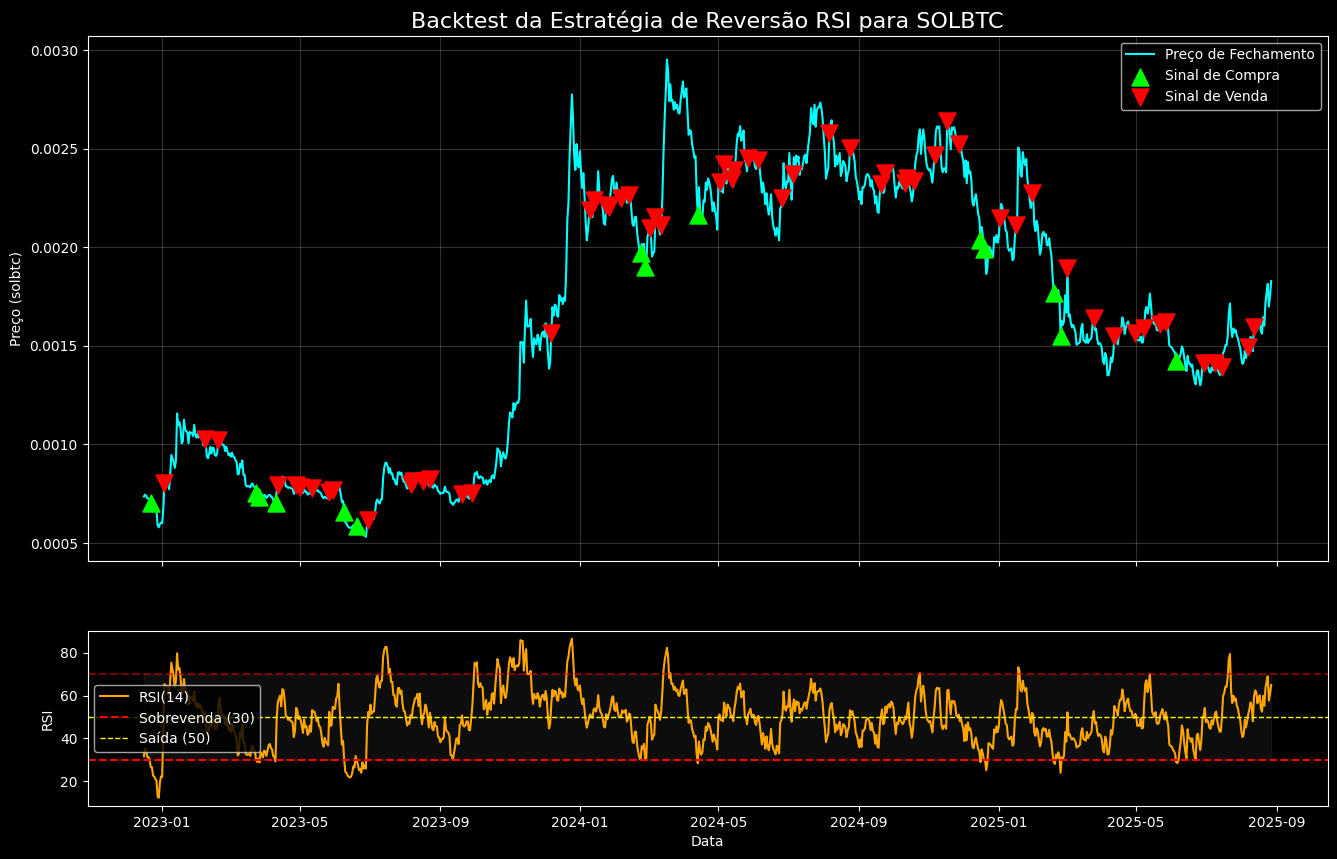

----- Processando XRPBTC -----


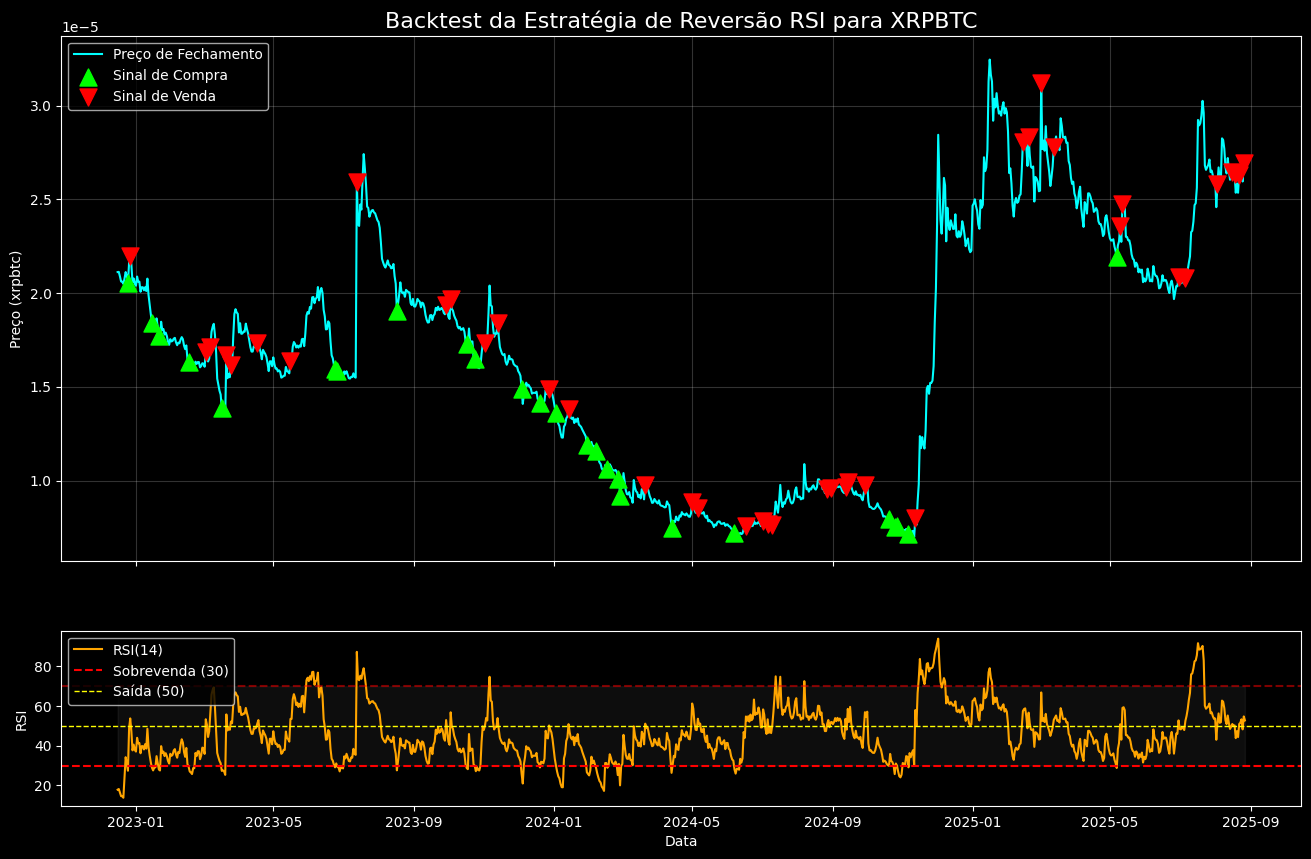



===== RESUMO CONSOLIDADO DOS RESULTADOS (ESTRATÉGIA RSI) =====
  Ativo  Rentabilidade Estratégia (%)  Rentabilidade B&H (%)  Num Trades
 adabtc                        -26.19                 -51.70          18
 ethbtc                          9.69                 -42.30          22
linkbtc                         15.89                 -39.70          20
 solbtc                         46.53                 148.41          16
 xrpbtc                        121.95                  26.28          26


In [15]:
# ==============================================================================
# TRADEBAO POC - NOTEBOOK 03: BACKTEST RSI (V5 - SEM DEPENDÊNCIAS EXTERNAS)
# ==============================================================================

# --- CÉLULA ÚNICA, COMPLETA E INDEPENDENTE ---

# 1. IMPORTS BÁSICOS (SEM PANDAS_TA)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 2. NOSSA PRÓPRIA FUNÇÃO PARA CALCULAR O RSI
def calculate_rsi(data, period=14):
    """
    Calcula o Índice de Força Relativa (RSI) usando apenas pandas.
    """
    close_delta = data['Close'].diff()

    # Separa ganhos e perdas
    gain = close_delta.clip(lower=0)
    loss = -1 * close_delta.clip(upper=0)

    # Usa a Média Móvel Exponencial (EWMA) para suavizar os ganhos e perdas
    # Isso é o padrão para o cálculo do RSI (Wilder's Smoothing)
    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()

    # Calcula a Força Relativa (RS)
    rs = avg_gain / avg_loss

    # Calcula o RSI
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    return data


# 3. CONFIGURAÇÕES GERAIS
simbolos = ["adabtc", "ethbtc", "linkbtc", "solbtc", "xrpbtc"]
capital_inicial_btc = 1.0

# 4. PARÂMETROS DA ESTRATÉGIA RSI
rsi_periodo = 14
rsi_sobrevenda = 30
rsi_saida = 50

# Dataframe para consolidar os resultados
resultados_finais = []

for simbolo in simbolos:
    caminho_do_arquivo = f'/content/drive/MyDrive/Colab Notebooks/TradeBaoCripto/dados_binance_{simbolo}.csv'

    try:
        df = pd.read_csv(caminho_do_arquivo, index_col='Open Time', parse_dates=True)
        print(f"----- Processando {simbolo.upper()} -----")
    except FileNotFoundError:
        print(f"ERRO: Arquivo não encontrado para {simbolo}. Pulando para o próximo.")
        continue

    # Chamando NOSSA função para calcular o RSI
    df = calculate_rsi(df, period=rsi_periodo)
    df.dropna(inplace=True)

    # Gerar os Sinais de Trade
    df['sinal_compra'] = (df['RSI'].shift(1) > rsi_sobrevenda) & (df['RSI'] <= rsi_sobrevenda)
    df['sinal_venda'] = (df['RSI'].shift(1) < rsi_saida) & (df['RSI'] >= rsi_saida)

    # Executar o Backtest
    capital_final_btc = capital_inicial_btc
    capital_altcoin = 0.0
    em_posicao = False
    trades = []

    for i, row in df.iterrows():
        if row['sinal_compra'] and not em_posicao:
            capital_altcoin = capital_final_btc / row['Close']
            capital_final_btc = 0.0
            em_posicao = True
            trades.append({'data': i, 'tipo': 'COMPRA', 'preco': row['Close']})
        elif row['sinal_venda'] and em_posicao:
            capital_final_btc = capital_altcoin * row['Close']
            capital_altcoin = 0.0
            em_posicao = False
            trades.append({'data': i, 'tipo': 'VENDA', 'preco': row['Close']})

    if em_posicao:
        capital_final_btc = capital_altcoin * df['Close'].iloc[-1]
        trades.append({'data': df.index[-1], 'tipo': 'VENDA FORÇADA', 'preco': df['Close'].iloc[-1]})

    # Calcular e Armazenar os Resultados
    rentabilidade_estrategia = ((capital_final_btc - capital_inicial_btc) / capital_inicial_btc) * 100
    if not df.empty:
        rentabilidade_buy_and_hold = ((df['Close'].iloc[-1] - df['Close'].iloc[0]) / df['Close'].iloc[0]) * 100
    else:
        rentabilidade_buy_and_hold = 0
    num_trades = len(trades)

    resultados_finais.append({
        'Ativo': simbolo,
        'Rentabilidade Estratégia (%)': rentabilidade_estrategia,
        'Rentabilidade B&H (%)': rentabilidade_buy_and_hold,
        'Num Trades': num_trades
    })

    # Visualizar os Resultados
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    ax1.plot(df.index, df['Close'], label='Preço de Fechamento', color='cyan', linewidth=1.5)
    sinais_compra_df = df[df['sinal_compra']]
    ax1.scatter(sinais_compra_df.index, sinais_compra_df['Close'], marker='^', color='lime', s=150, label='Sinal de Compra', zorder=5)
    sinais_venda_df = df[df['sinal_venda']]
    ax1.scatter(sinais_venda_df.index, sinais_venda_df['Close'], marker='v', color='red', s=150, label='Sinal de Venda', zorder=5)
    ax1.set_title(f'Backtest da Estratégia de Reversão RSI para {simbolo.upper()}', fontsize=16)
    ax1.set_ylabel(f'Preço ({simbolo})')
    ax1.legend()
    ax1.grid(alpha=0.2)
    ax2.plot(df.index, df['RSI'], label='RSI(14)', color='orange')
    ax2.axhline(rsi_sobrevenda, color='red', linestyle='--', linewidth=1.5, label=f'Sobrevenda ({rsi_sobrevenda})')
    ax2.axhline(rsi_saida, color='yellow', linestyle='--', linewidth=1, label=f'Saída ({rsi_saida})')
    ax2.axhline(70, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    ax2.fill_between(df.index, rsi_sobrevenda, 70, color='gray', alpha=0.1)
    ax2.set_ylabel('RSI')
    ax2.set_xlabel('Data')
    ax2.legend()
    plt.show()

# --- RESUMO FINAL ---
print("\n\n===== RESUMO CONSOLIDADO DOS RESULTADOS (ESTRATÉGIA RSI) =====")
resumo_df = pd.DataFrame(resultados_finais)
resumo_df = resumo_df.round(2)
print(resumo_df.to_string(index=False))

In [16]:
# --- Célula 4: Resumo Final ---
print("\n\n===== RESUMO CONSOLIDADO DOS RESULTADOS =====")
resumo_df = pd.DataFrame(resultados_finais)
resumo_df = resumo_df.round(2) # Arredondando para 2 casas decimais
print(resumo_df.to_string(index=False))



===== RESUMO CONSOLIDADO DOS RESULTADOS =====
  Ativo  Rentabilidade Estratégia (%)  Rentabilidade B&H (%)  Num Trades
 adabtc                        -26.19                 -51.70          18
 ethbtc                          9.69                 -42.30          22
linkbtc                         15.89                 -39.70          20
 solbtc                         46.53                 148.41          16
 xrpbtc                        121.95                  26.28          26
